In [1]:
%matplotlib inline

In [2]:
import os
from PIL import Image
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow.keras.backend as K
from skimage import io
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import (
    Activation,
    Add,
    BatchNormalization,
    Concatenate,
    Conv2D,
    Dropout,
    Input,
    MaxPool2D,
    MaxPooling2D,
    UpSampling2D,
)
from scipy.spatial.transform import Rotation
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.utils import Sequence, plot_model

In [3]:
tf.config.experimental.set_memory_growth(tf.config.get_visible_devices()[1], True)

In [2]:
def abv(a):
    return a

1321321asda

# [U-Net: Convolutional Networks for Biomedical Image Segmentation](https://arxiv.org/pdf/1505.04597v1.pdf)

### 1. Abstract.

 The architecture consists of a contracting path to capture context and a symmetric expanding path that enables precise localization. Segmentation of a 512x512 image takes less than a second on a recent GPU.

### _Table of Contents_
1. [Goal](#1.-Abstract)
2. [Abstract](#2.-Introduction)
3. [Network Architecture](#3.-Network-Architecture)
4. [Training](#4.-Training)
    - [4.1. Data Augmentation](#4.1.-Data-Augmentation)
5. [Experiments](#5.-Experiments)
6. [Conclusion](#6.-Conclusion)
7. [Code](#7.-Code)
8. [Resources](#8.-Resources)

### 2. Introduction

Deep convolutional networks outperformed the state of the art in many visual recognition tasks, e.g. In the last two years, deep networks have outperformed state-of-the-art in visual recognition.

 Ciresan et al. trained a network in a sliding-window setup to predict the class label of each pixel by providing a local region (patch) around that pixel as input. The resulting network won the EM segmentation challenge at ISBI 2012 by a large margin.

[Figure 1: ](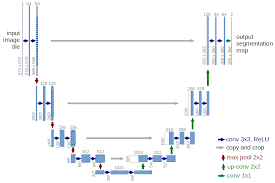)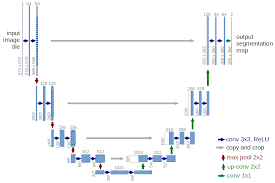

 There is a trade-off between localization accuracy and the use of context. Larger patches require more max-pooling layers that reduce the localization accuracy. Small patches allow the network to see only little context. More recent approaches proposed a classifier output that takes into account features from multiple layers.
 
Autours build upon a more elegant architecture, the so-called “fully-fully-convolutional network” . They modify and extend this architecture such that it works with very few training images and yields more precise segmentations. The main idea in is to supplement a usual contracting network by adding successive layers.

[Figure 2: ](https://miro.medium.com/max/1400/1*OBsHDeLDiIgbU60oeFsjMg.png)![](https://miro.medium.com/max/1400/1*OBsHDeLDiIgbU60oeFsjMg.png)

One modification in architecture is that in the upsampling part have also a large number of feature channels, which allow the network to propagate context information to higher resolution layers. As a consequence, the expansive path is more or less symmetric to the contracting path, and yields a u-shaped architecture.
 
  Authors use excessive data augmentation by applying elastic deformations to the available training images. This allows the network to learn invariance to such deformations without the need to see these transformations in the annotated image corpus. This is particularly important in biomedical segmentation.
  
  Another challenge in many cell segmentation tasks is the separation of touching objects of the same class; see Figure 3.
  
  The resulting network is applicable to various biomedical segmentation problems. In this paper, they show results on the segmentation of neuronal structures in EM stacks (an ongoing competition started at ISBI 2012), where they out-performed the network of Ciresan et al.

[Figure 3: ](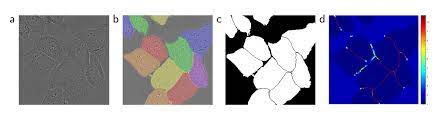)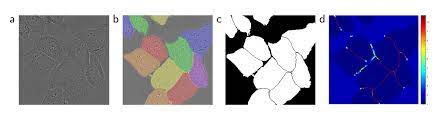

### 3.  Network Architecture

 The network architecture is illustrated in Figure 1. It consists of a contracting path (left side) and an expansive path (right side) The contracting path follows the typical architecture of a convolutional network. The expansive path consists of an upsampling of the feature map followed by a 2x2 convolution (up-convolution) that halves the number of feature channels. At the final layer a 1x1 convolution is used to map each 64-Component feature vector to the desired number of classes.

### 4. Training

The input images and segmentation maps are used to train the network with the stochastic gradient descent implementation of Caffe. Due to the unpadded convolutions, the output image is smaller than the input image by a constant border width. To minimize the overhead and make maximum use of the GPU memory, we favor large input tiles over a large batch size and hence reduce the batch to a single image. The energy function is computed by a pixel-wise soft-max over the final feature map combined with the cross entropy loss function. The soft-max is
defined as $p_k(x)=exp(a_k(x)) / \left(\sum_{k^{\prime}=1}^{K}exp(a_k^{\prime}(x))\right)$
where $a_k(x)$ denotes the activation in feature channel $k$ at the pixel position $x\in \Omega $ with $\Omega \subset \mathbb{Z}^2$. $K$ is the number of classes and $p_k(x)$  is the approximated maximum-function. I.e. $p_k(x)\approx 0$ for all other $k$. The cross entropy then penalizes at each position the deviation of $p_{\ell(x)}(x)$  from 1 using

$E = \sum_{x \in \Omega}w(x)log(p_{\ell(x)}(x)$

where $\ell : \Omega \to \{ 1,\dotsc,K\}$ is the true label of each pixel and $w : \Omega \to \mathbb{R}$  is a weight map that we introduced to give some pixels more importance in the
training. We pre-compute the weight map for each ground truth segmentation to compensate the different frequency of pixels from a certain class in the training data set, and to force the network to learn the small separation borders that we introduce between touching cells (See Figure 3c and d). The separation border is computed using morphological operations. The
weight map is then computed as

$w(x)=w_0 . exp\left(-\frac{(d_1(x)+d_2(x))^2}{2\sigma^2}\right)$
where $w_c:\Omega \ to \mathbb{R}$ R is the weight map to balance the class frequencies. $d_1 : \Omega \ to \mathbb{R}$ denotes the distance to the border of the nearest cell and $d_2 : \Omega \ to \mathbb{R}$ the distance to the border of the second nearest cell. In our experiments we set $w_0 = 10$  and $\sigma \approx 5$ pixels.

 In deep networks with many convolutional layers and different paths through the network, a good initialization of the weights is extremely important. Ideally the initial weights should be adapted such that each feature map in the network has approximately unit variance. E.g. for a 3x3 convolution and 64 feature channels in the previous layer, $N = 9 · 64 = 576$.

### 4.1. Data Augmentation

 Random elastic deformations of the training samples seem to be the key concept to train a segmentation network with very few annotated images. Drop-out layers at the end of the contracting path perform further implicit data augmentation. They generate smooth deformations using random displacement vectors on a coarse 3 by 3 grid.

### 5. Experiments

 The u-net (averaged over 7 rotated versions of the input data) achieves without any further pre- or post-processing a warping error of 0.0003529 (the new best score, see Table 1) and 0.0382. The data set is provided by the EM segmentation challenge that was started at ISBI 2012 and is still open for new contributions. The evaluation is done by thresholding the map at 10 different levels and computation of the “warping’error”, the ‘Rand error’ and the. “pixel error”.

[Table 1](https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcRAQXtDUKR5iqAknuXv4b14GdRp_-rUEOm2mZ6Aibx5aQr6ToTn0SXv2PcXg3Oo1tXMqHc&usqp=CAU)![](https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcRAQXtDUKR5iqAknuXv4b14GdRp_-rUEOm2mZ6Aibx5aQr6ToTn0SXv2PcXg3Oo1tXMqHc&usqp=CAU)

[Fig. 4](https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcQokaltg2n5zAwpUuFFa0v998sswWdSuqCdjTKAveZeKfjYaVb4HOsAj19At6ZiB1TB9aA&usqp=CAU)![](https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcQokaltg2n5zAwpUuFFa0v998sswWdSuqCdjTKAveZeKfjYaVb4HOsAj19At6ZiB1TB9aA&usqp=CAU)

[Table 2](https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcR-GBC4jYJasviAJqduKiuaTrR-4OZIp-IS0rY1H8g3RavXp1cYa3Uhtpr6jImpfx2zkw&usqp=CAU)![](https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcR-GBC4jYJasviAJqduKiuaTrR-4OZIp-IS0rY1H8g3RavXp1cYa3Uhtpr6jImpfx2zkw&usqp=CAU)

### 6. Conclusion

 The u-net architecture achieves very good performance on very different biomedical segmentation applications. It only needs very few annotated images and has a very reasonable training time of only 10 hours on a NVidia Titan GPU (6 GB).

### 7. Code


Dataset represents a 5x5x5µm section taken from the CA1 hippocampus region of the brain, corresponding to a 1065x2048x1536 volume. We annotated mitochondria in two sub-volumes. Each sub-volume consists of the first 165 slices of the 1065x2048x1536 image stack. 

Data is collected [here](https://www.epfl.ch/labs/cvlab/data/data-em/). We only collected 2 stacks. 'Download training sub-volume' and 'Download groundtruth training sub-volume'.

In [4]:
image_dataset = []
name_image = []
mask_dataset = [] 
mask_name = []

image_directory = os.listdir('mitochondria/train')
for i, image_name in enumerate(image_directory):  
    if (image_name.split('.')[1] == 'tif'):
        image = cv2.imread('mitochondria/train/'+image_name, 0)
        image = Image.fromarray(image)
        image = image.resize((256, 256))
        image_dataset.append(np.array(image))
        name_image.append(image_name)
        
mask_directory='mitochondria/test'
masks = os.listdir(mask_directory)
for i, image_name in enumerate(masks):
    if (image_name.split('.')[1] == 'tif'):
        image = cv2.imread('mitochondria/test/'+image_name, 0)
        image = Image.fromarray(image)
        image = image.resize((256, 256))
        mask_dataset.append(np.array(image))
        mask_name.append(image_name)


We read the data and make them the same size (so they take up less memory when we train and we're sure that all images are of the size we've chosen). We overwrite them in lists so that we can later pass them to pandas.

In [5]:
data = pd.DataFrame(
    {
        'image_names':name_image,
        "images": image_dataset,
        'mask_names':mask_name,
        "masks": mask_dataset,
    }
)


Let's see if we have read and collected the data correctly.


We mix them up.

In [6]:
data=data.sample(len(data),random_state = 1234)

In [7]:
data.head()

,image_names,images,mask_names,masks
79,image21.tif,"[[94, 100, 119, 137, 146, 151, 148, 145, 140, ...",mask21.tif,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
27,image122.tif,"[[163, 157, 167, 178, 185, 188, 187, 187, 187,...",mask122.tif,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
29,image124.tif,"[[160, 158, 154, 171, 177, 176, 177, 180, 187,...",mask124.tif,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
99,image4.tif,"[[143, 129, 117, 112, 115, 123, 128, 126, 121,...",mask4.tif,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
91,image32.tif,"[[105, 119, 134, 147, 163, 161, 153, 149, 144,...",mask32.tif,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."



It looks right, but do the masks match the images? Let's check.

image1.tif mask1.tif
(256, 256) (256, 256)


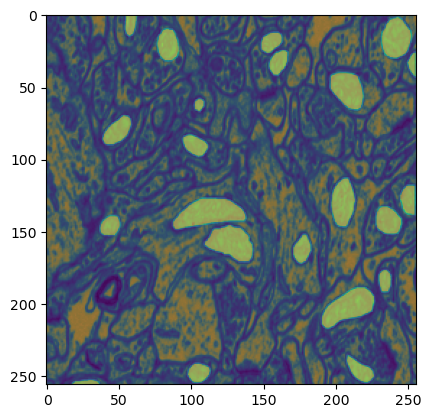

In [8]:
print(data.image_names[1],data.mask_names[1])
plt.imshow(data.images[1])
plt.imshow(data.masks[1],alpha=0.5)
print(data.masks[1].shape,data.images[1].shape)
plt.show()

Looks correct.

In [9]:
#normalize image and masks
image_dataset = np.expand_dims(list(data.images),3) /256.
mask_dataset = np.expand_dims(list(data.masks),3) /256.

(256, 256, 1) (256, 256, 1)


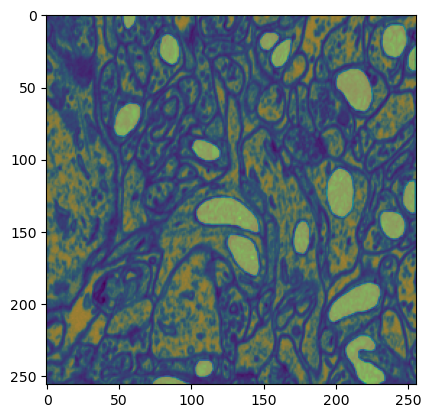

In [10]:
plt.imshow(image_dataset[0])
# plt.show()
plt.imshow(mask_dataset[0],alpha=0.45)
print(image_dataset[0].shape,mask_dataset[0].shape)


It looks right after processing.


Let's split the data into training and testing sets.

In [11]:
X_train, X_test, y_train, y_test = train_test_split(image_dataset, mask_dataset, test_size = 0.3, random_state = 1234)


Building the model.

In [12]:
def resblock(X, f):
    X_copy = X

    X = Conv2D(f, kernel_size=(1, 1), kernel_initializer="he_normal")(X)
    X = BatchNormalization()(X)
    X = Activation("relu")(X)

    X = Conv2D(f, kernel_size=(3, 3), padding="same", kernel_initializer="he_normal")(X)
    X = BatchNormalization()(X)

    X_copy = Conv2D(f, kernel_size=(1, 1), kernel_initializer="he_normal")(X_copy)
    X_copy = BatchNormalization()(X_copy)

    X = Add()([X, X_copy])
    X = Activation("relu")(X)

    return X

In [13]:
def upsample_concat(x, skip):
    X = UpSampling2D((2, 2))(x)
    merge = Concatenate()([X, skip])

    return merge

In [14]:
X_input = Input((256, 256, 1))

conv_1 = Conv2D(
    16, 3, activation="relu", padding="same", kernel_initializer="he_normal"
)(X_input)
conv_1 = BatchNormalization()(conv_1)
conv_1 = Conv2D(
    16, 3, activation="relu", padding="same", kernel_initializer="he_normal"
)(conv_1)
conv_1 = BatchNormalization()(conv_1)
pool_1 = MaxPool2D((2, 2))(conv_1)

conv_2 = resblock(pool_1, 32)
pool_2 = MaxPool2D((2, 2))(conv_2)

conv_3 = resblock(pool_2, 64)
pool_3 = MaxPool2D((2, 2))(conv_3)

conv_4 = resblock(pool_3, 128)
pool_4 = MaxPool2D((2, 2))(conv_4)

conv_5 = resblock(pool_4, 256)

up_1 = upsample_concat(conv_5, conv_4)
up_1 = resblock(up_1, 128)

up_2 = upsample_concat(up_1, conv_3)
up_2 = resblock(up_2, 64)

up_3 = upsample_concat(up_2, conv_2)
up_3 = resblock(up_3, 32)

up_4 = upsample_concat(up_3, conv_1)
up_4 = resblock(up_4, 16)

out = Conv2D(
    1, (1, 1), kernel_initializer="he_normal", padding="same", activation="sigmoid"
)(up_4)

u_net = Model(X_input, out)


Here's what the model looks like.

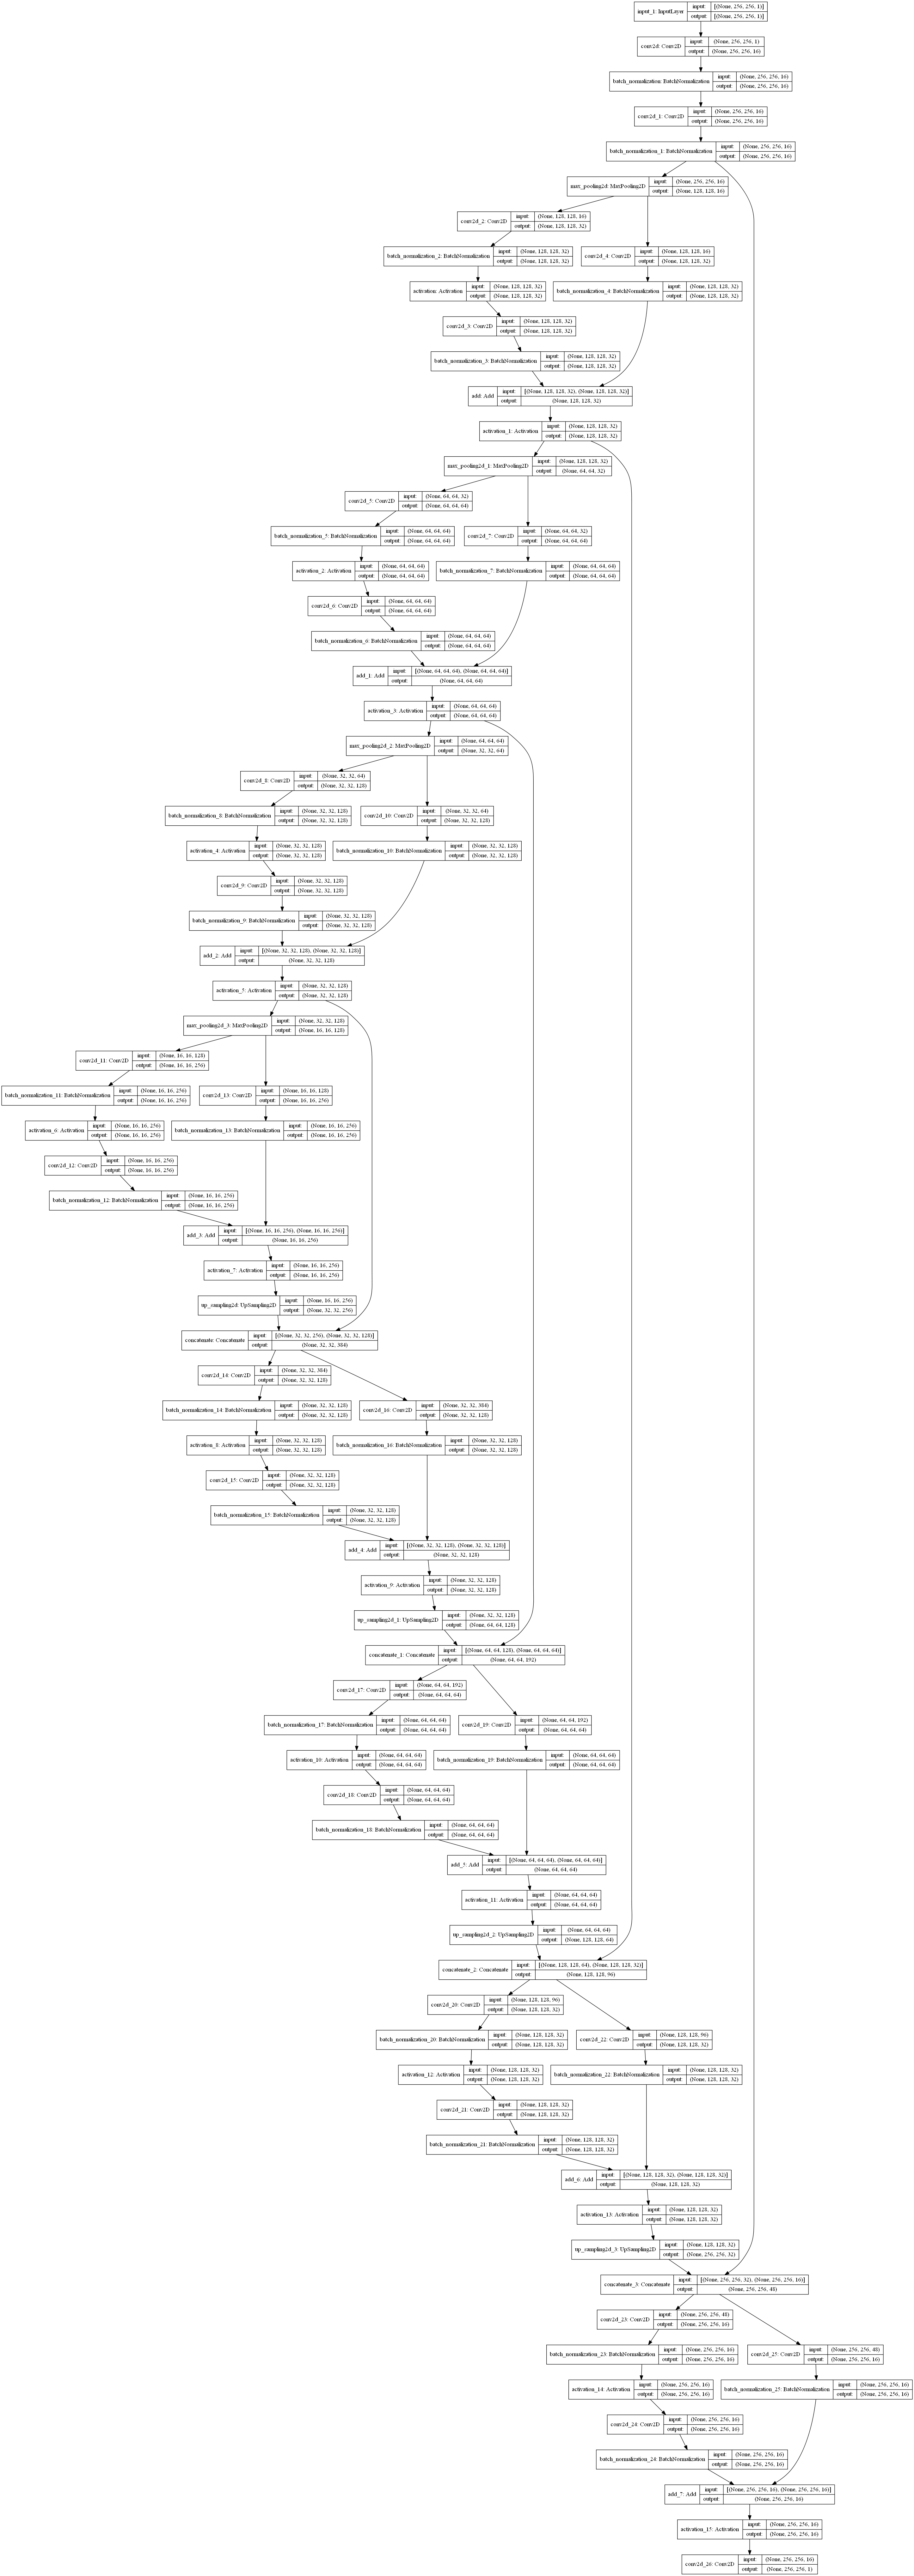

In [15]:
plot_model(u_net, show_shapes=True)

In [16]:
def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    dice = (2.0 * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return dice


def dice_coef_loss(y_true, y_pred, smooth=1):
    return 1 - dice_coef(y_true, y_pred, smooth)

In [17]:
adam = tf.keras.optimizers.Adam(
    learning_rate=0.001
)  
u_net.compile(optimizer=adam, loss=dice_coef_loss, metrics=[dice_coef])

In [18]:
trained_u_net = u_net.fit(X_train, y_train, 
                    batch_size = 4,  
                    epochs=25, 
                    validation_data=(X_test, y_test), 
                    shuffle=False,
                    verbose=1,
                    )

Epoch 1/25
29/29 [==============================] - 13s 183ms/step - loss: 0.7049 - dice_coef: 0.2971 - val_loss: 0.8853 - val_dice_coef: 0.1150
Epoch 2/25
29/29 [==============================] - 2s 81ms/step - loss: 0.4641 - dice_coef: 0.5371 - val_loss: 0.8886 - val_dice_coef: 0.1116
Epoch 3/25
29/29 [==============================] - 2s 81ms/step - loss: 0.3244 - dice_coef: 0.6764 - val_loss: 0.9216 - val_dice_coef: 0.0785
Epoch 4/25
29/29 [==============================] - 2s 81ms/step - loss: 0.2278 - dice_coef: 0.7728 - val_loss: 0.9649 - val_dice_coef: 0.0351
Epoch 5/25
29/29 [==============================] - 2s 81ms/step - loss: 0.1686 - dice_coef: 0.8318 - val_loss: 0.9751 - val_dice_coef: 0.0249
Epoch 6/25
29/29 [==============================] - 2s 80ms/step - loss: 0.1371 - dice_coef: 0.8632 - val_loss: 0.9810 - val_dice_coef: 0.0191
Epoch 7/25
29/29 [==============================] - 2s 81ms/step - loss: 0.1203 - dice_coef: 0.8797 - val_loss: 0.9859 - val_dice_coef: 0.01

In [19]:
_, acc = u_net.evaluate(X_test, y_test)
print(f"Accuracy is {acc*100:.2f}%")

2/2 [==============================] - 3s 1s/step - loss: 0.0645 - dice_coef: 0.9356
Accuracy is 93.56%



Let's save it.

In [20]:
# u_net.save('u_net_model.h5')

In [21]:
# u_net_loaded = load_model(
#     "u_net_model.h5",
#     custom_objects={"dice_coef": dice_coef, "dice_coef_loss": dice_coef_loss},
# )

Also we save the results from the training.

In [22]:
# model_stat=pd.Series({"loss":trained_u_net.history['loss'],
#                       'val_loss':trained_u_net.history['val_loss'],
#                       'accuracy':trained_u_net.history['dice_coef'],
#                       'val_accuracy':trained_u_net.history['val_dice_coef']
#                      })

In [23]:
# model_stat.to_pickle("u_net_loss_and_score.pkl")

Here's what they look like:

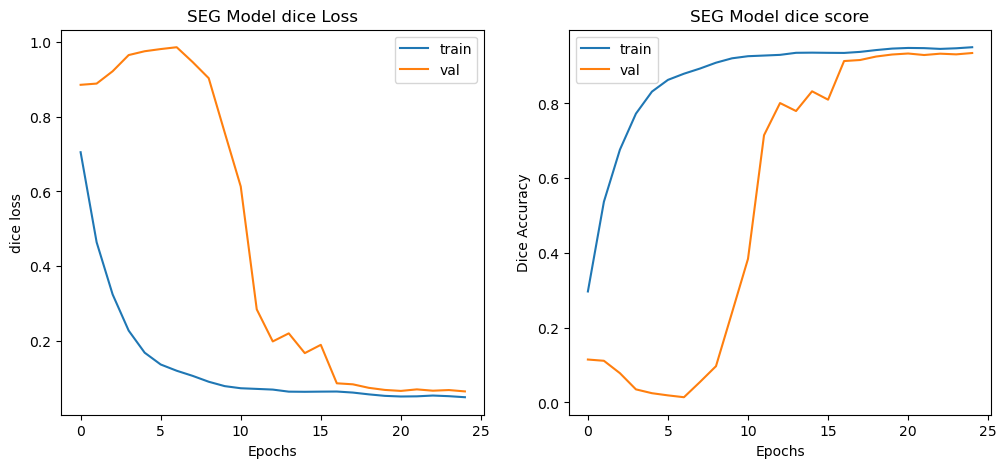

In [24]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(trained_u_net.history["loss"])
plt.plot(trained_u_net.history["val_loss"])
plt.title("SEG Model dice Loss")
plt.ylabel("dice loss")
plt.xlabel("Epochs")
plt.legend(["train", "val"])

plt.subplot(1, 2, 2)
plt.plot(trained_u_net.history["dice_coef"])
plt.plot(trained_u_net.history["val_dice_coef"])
plt.title("SEG Model dice score")
plt.ylabel("Dice Accuracy")
plt.xlabel("Epochs")
plt.legend(["train", "val"]);

 Checking out how it handles predicting after training for it.

(1, 256, 256, 1)


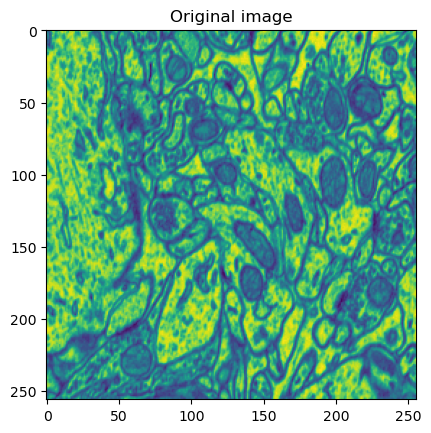

In [25]:
random_num = np.random.randint(0, len(X_test)-1)
test_img = X_test[random_num]
ground_truth=y_test[random_num]


test_img_norm=test_img[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img_norm, 0) # We change the shape of the image to : 1,256,256,1 to make it possible to input it to the model for predicting.

plt.imshow(test_img_input[0,:,:,:])
print(test_img_input.shape)
plt.title('Original image')
plt.show()

prediction = (u_net.predict(test_img_input)[0,:,:,0])


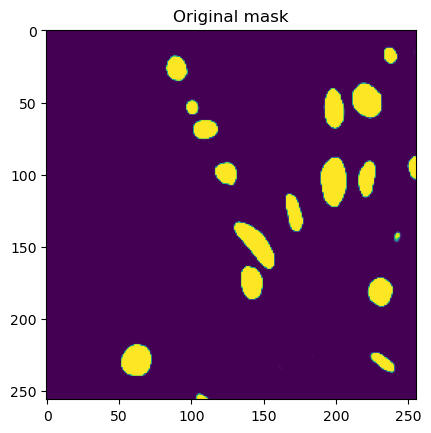

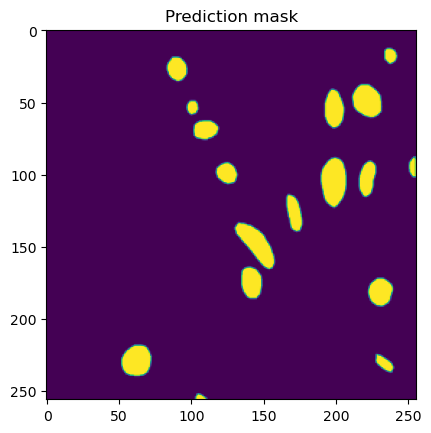

In [26]:
plt.imshow(prediction)
plt.title("Original mask")
plt.show()
plt.imshow(ground_truth)
plt.title("Prediction mask")
plt.show()

### 8. Resources

[Article](https://arxiv.org/pdf/1505.04597v1.pdf)

[Digital Sreeni](https://www.youtube.com/watch?v=csFGTLT6_WQ)

[Dataset](https://www.epfl.ch/labs/cvlab/data/data-em/)